# Pipelines subpackage

The `opr.pipelines` subpackage contains ready-to-use pipelines for model inference. In this tutorial we will examine how to build database and utilize`opr.pipelines.localization.TopologicalLocalizationPipeline`.

## Imports & functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import cv2
from hydra.utils import instantiate
import numpy as np
from omegaconf import OmegaConf
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from geotransformer.utils.registration import compute_registration_error
from geotransformer.utils.pointcloud import get_transform_from_rotation_translation

from opr.datasets.itlp import ITLPCampus
from opr.pipelines.localization import TopologicalLocalizationPipeline
from opr.pipelines.place_recognition import PlaceRecognitionPipeline
from opr.pipelines.registration import PointcloudRegistrationPipeline
from opr.datasets.augmentations import DefaultImageTransform

def pose_to_matrix(pose):
    """From the 6D poses in the [tx ty tz qx qy qz qw] format to 4x4 pose matrices."""
    position = pose[:3]
    orientation_quat = pose[3:]
    rotation = Rotation.from_quat(orientation_quat)
    pose_matrix = np.eye(4)
    pose_matrix[:3,:3] = rotation.as_matrix()
    pose_matrix[:3,3] = position
    return pose_matrix

def compute_error(estimated_pose, gt_pose):
    """For the 6D poses in the [tx ty tz qx qy qz qw] format."""
    estimated_pose = pose_to_matrix(estimated_pose)
    gt_pose = pose_to_matrix(gt_pose)
    error_pose = np.linalg.inv(estimated_pose) @ gt_pose
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = Rotation.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / np.pi
    angle_error = abs(90 - abs(angle_error-90))
    return dist_error, angle_error

def compute_translation_error(gt_pose, pred_pose):
    """Fore 4x4 pose matrices."""
    gt_trans = gt_pose[:3, 3]
    pred_trans = pred_pose[:3, 3]
    error = np.linalg.norm(gt_trans - pred_trans)
    return error

def compute_rotation_error(gt_pose, pred_pose):
    """For the 4x4 pose matrices."""
    gt_rot = Rotation.from_matrix(gt_pose[:3, :3])
    pred_rot = Rotation.from_matrix(pred_pose[:3, :3])
    error = Rotation.inv(gt_rot) * pred_rot
    error = error.as_euler('xyz', degrees=True)
    error = np.linalg.norm(error)
    return error

def compute_absolute_pose_error(gt_pose, pred_pose):
    """For the 4x4 pose matrices."""
    rotation_error = compute_rotation_error(gt_pose, pred_pose)
    translation_error = compute_translation_error(gt_pose, pred_pose)
    return rotation_error, translation_error

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Usage example - TopologicalLocalizationPipeline

#### Weights download

You can download the `multi-image_lidar_late-fusion_itlp-finetune.pth` from the HuggingFace model hub:
https://huggingface.co/OPR-Project/PlaceRecognition-NCLT.

```bash
wget https://huggingface.co/OPR-Project/PlaceRecognition-NCLT/resolve/main/multi-image_lidar_late-fusion_itlp-finetune.pth
```

#### Dataset download

You can download the dataset:

- Kaggle:
  - [ITLP Campus Indoor](https://www.kaggle.com/datasets/alexandermelekhin/itlp-campus-indoor)
- Hugging Face:
  - [ITLP Campus Indoor](https://huggingface.co/datasets/OPR-Project/ITLP-Campus-Indoor)


#### How to build the database

The minimum requirement to initialize the `PlaceRecognitionPipeline` is that the database directory should contain the `index.faiss` file and the `track.csv` file.

The `index.faiss` file is a Faiss index, which contains the descriptors of the database. The `track.csv` file contains the metadata of the database, including the id and the pose of the descriptors.

The details on how to create the database are described in the [build_database.ipynb](./build_database.ipynb) notebook.

Note that the actual data are not required, as the pipeline will only load the `index.faiss` and the `track.csv` file. This can be useful in the real-world scenario, where the database size is too large to be stored on the local machine.

In [3]:
DATABASE_DIR = "/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_indoor/00_2023-10-25-night/floor_5"
DATABASE_TRACK_DIR = "/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_indoor/00_2023-10-25-night/floor_5"
QUERY_TRACK_DIR = "/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_indoor/01_2023-11-09-twilight/floor_5"

DEVICE = "cuda"

MODEL_CONFIG_PATH = "../configs/model/place_recognition/multi-image_lidar_late-fusion.yaml"
WEIGHTS_PATH = "../weights/place_recognition/multi-image_lidar_late-fusion_itlp-finetune.pth"

In [4]:
query_dataset = ITLPCampus(
    dataset_root=QUERY_TRACK_DIR,
    sensors=["lidar", "front_cam", "back_cam"],
    mink_quantization_size=0.5,
    load_semantics=False,
    load_text_descriptions=False,
    load_text_labels=False,
    load_aruco_labels=False,
    indoor=False,
    image_transform=DefaultImageTransform()
)

In [5]:
query_dataset[0].keys()

dict_keys(['idx', 'pose', 'image_front_cam', 'image_back_cam', 'pointcloud_lidar_coords', 'pointcloud_lidar_feats'])

[2025-05-04 20:54:46,093] [ WARNING] image.py:661 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


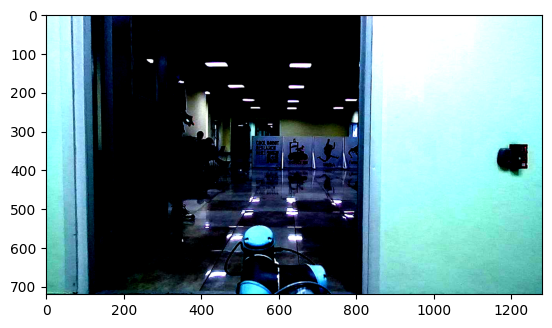

In [6]:
plt.imshow(query_dataset[0]["image_front_cam"].permute(1, 2, 0).numpy())

[2025-05-04 20:54:46,527] [ WARNING] image.py:661 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9131651..2.6399999].


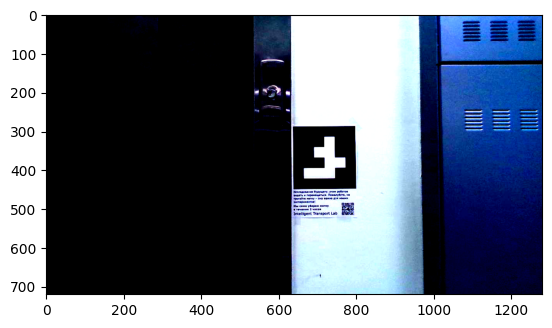

In [7]:
plt.imshow(query_dataset[0]["image_back_cam"].permute(1, 2, 0).numpy())

In [8]:
model_config = OmegaConf.load(MODEL_CONFIG_PATH)
model = instantiate(model_config)

2025-05-04 20:54:50.161 | WARNING  | opr.models.place_recognition.pointmamba:<module>:16 - The 'pointmamba' package is not installed. Please install it manually if neccessary.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/docker_opr/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:10<00:00, 4.68MB/s]


In [9]:
pr_pipe = PlaceRecognitionPipeline(
    database_dir=DATABASE_DIR,
    model=model,
    model_weights_path=WEIGHTS_PATH,
    device=DEVICE,
)

In [10]:
REGISTRATION_MODEL_CONFIG_PATH = "../configs/model/registration/geotransformer_kitti.yaml"
REGISTRATION_WEIGHTS_PATH = "../weights/registration/geotransformer_kitti.pth"

geotransformer = instantiate(OmegaConf.load(REGISTRATION_MODEL_CONFIG_PATH))

registration_pipe = PointcloudRegistrationPipeline(
    model=geotransformer,
    model_weights_path=REGISTRATION_WEIGHTS_PATH,
    device="cuda",  # the GeoTransformer currently only supports CUDA
    voxel_downsample_size=0.3,  # recommended for geotransformer_kitti configuration
)

[2025-05-04 20:55:01,387] [ WARNING] __init__.py:14 - Cannot import HRegNet: No module named 'hregnet'


In [11]:
database = ITLPCampus(
    dataset_root=DATABASE_TRACK_DIR,
    sensors=["lidar", "front_cam", "back_cam"],
    mink_quantization_size=0.5,
    load_semantics=False,
    load_text_descriptions=False,
    load_text_labels=False,
    load_aruco_labels=False,
    indoor=False,
    image_transform=DefaultImageTransform()
)

pipe = TopologicalLocalizationPipeline(
    database=database,
    place_recognition_pipeline=pr_pipe,
    registration_pipeline=registration_pipe,
    pointclouds_subdir='lidar',
    camera_names=['front_cam', 'back_cam'],
    multi_sensor_fusion=True,
    edge_threshold=5.0,
    top_k=5
)

Start building topological graph from database
Preprocessing database...
Extracting topological connectivity...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [01:40<00:00,  2.27it/s]

Done!


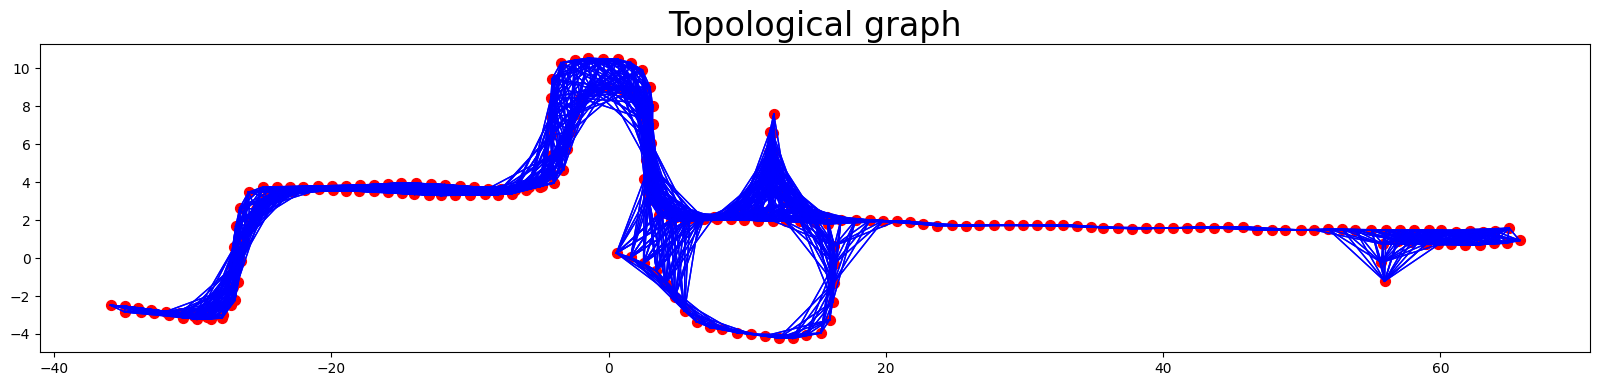

In [12]:
node_poses = []
for x, y, theta, cloud in pipe.graph.vertices:
    node_poses.append([x, y, theta])
node_poses = np.array(node_poses)
plt.figure(figsize=(20, 4))
plt.title('Topological graph', fontsize=24)
plt.scatter(node_poses[:, 0], node_poses[:, 1], color='r', s=50)
for i in range(len(pipe.graph.vertices)):
    for j, pose in pipe.graph.adj_lists[i]:
        plt.plot([node_poses[i, 0], node_poses[j, 0]], [node_poses[i, 1], node_poses[j, 1]], color='b', lw=1)

In [13]:
sample_data = query_dataset[0]
sample_pose_gt = sample_data.pop("pose")  # removing those keys are not necessary, we just
sample_data.pop("idx")                    # want to simulate that we pass the data without GT information :)
print(f"sample_data.keys() = {sample_data.keys()}")
sample_output = pipe.infer(sample_data)
print(f"sample_output.keys() = {sample_output.keys()}")

print("---")
print(f"sample_output['db_match_pose'] = {sample_output['db_match_pose']}")
print(f"sample_output['estimated_pose'] = {sample_output['estimated_pose']}")
print(f"pose_gt = {sample_pose_gt.numpy()}")
dist_error, angle_error = compute_error(sample_output['estimated_pose'], sample_pose_gt.numpy())
print(f"dist_error = {dist_error}, angle_error = {angle_error}")

sample_data.keys() = dict_keys(['image_front_cam', 'image_back_cam', 'pointcloud_lidar_coords', 'pointcloud_lidar_feats'])
sample_output.keys() = dict_keys(['db_match_pose', 'current_node', 'estimated_pose'])
---
sample_output['db_match_pose'] = [[-9.61610246e-01 -2.74336564e-01  6.72197117e-03  1.58232093e+00]
 [ 2.73954615e-01 -9.58270950e-01  8.16434628e-02  3.26217003e-02]
 [-1.59563174e-02  8.03507054e-02  9.96638932e-01  4.00036896e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
sample_output['estimated_pose'] = [-5.33588295e-01 -2.20848603e-01  3.99817318e+02 -4.08443807e-02
  3.50296151e-03  3.40342932e-03  9.99153583e-01]
pose_gt = [ 2.1369928e-02 -1.5203454e-01  3.9998340e+02 -5.2527422e-03
  2.5283924e-04 -7.5020397e-04  9.9998587e-01]
dist_error = 0.5833495128400255, angle_error = 4.124362193190777


In [14]:
import warnings
from tqdm import tqdm_notebook
warnings.filterwarnings("ignore")

PR_MATCH_THRESHOLD = 25.0
pr_matches = []
rre_list = []
rte_list = []
times = []

for sample in tqdm_notebook(query_dataset):
    gt_pose = sample.pop("pose")
    gt_pose = get_transform_from_rotation_translation(Rotation.from_quat(gt_pose[3:]).as_matrix(), gt_pose[:3])

    start_time = time()
    pipe_out = pipe.infer(sample)
    times.append(time() - start_time)

    estimated_pose = pipe_out["estimated_pose"]
    estimated_pose = get_transform_from_rotation_translation(Rotation.from_quat(estimated_pose[3:]).as_matrix(), estimated_pose[:3])

    _, db_match_distance = compute_registration_error(gt_pose, estimated_pose)
    pr_matched = db_match_distance <= PR_MATCH_THRESHOLD
    pr_matches.append(pr_matched)

    rre, rte = compute_registration_error(gt_pose, estimated_pose)
    print(rre, rte)
    rre_list.append(rre)
    rte_list.append(rte)

  0%|          | 0/319 [00:00<?, ?it/s]

4.124362172902061 0.5833514257702191
88.03186083326214 21.434708408151035
55.02155729107002 3.7157834068726103
6.408197289993378 6.42876253787825
5.1791035775651295 14.059795196153276
3.59889553809513 0.38207647492994723
2.677323697582475 0.4400062694581896
173.22482681771635 17.56980129697853
3.166409924008891 0.6648579378160219
10.225208328162894 20.63498618428102
2.6016752414102546 37.8103235185219
179.60067418373612 6.596472089572876
5.8743929781383315 22.007764544526232
147.26938442640656 22.16179422145841
86.58350517546504 22.145868006694027
179.40387224980228 19.049282668079396
170.62685357439727 22.47705892460492
17.398211898253525 4.543177619003433
168.31720419842787 18.848670626460468
165.13054132183072 19.675264772406514
169.17363564026056 19.30682645242698
8.163910712087509 1.7096570947144127
4.195678546572221 18.143071461379094
177.94473453631278 17.163787882665197
3.7505356836356567 1.1858928751822455
4.2538711477968825 1.3003424354409603
4.010226522198224 0.9359043325455

In [15]:
print(f"PlaceRecognition R@1 = {np.mean(pr_matches):0.3f}")
print(f"Localization Mean RRE = {np.mean(rre_list):0.3f}")
print(f"Localization Mean RTE = {np.mean(rte_list):0.3f}")

print(f"Localization Median RRE = {np.median(rre_list):0.3f}")
print(f"Localization Median RTE = {np.median(rte_list):0.3f}")

print(f"Mean Time = {(np.mean(times) * 1000):0.2f} ms")

PlaceRecognition R@1 = 0.947
Localization Mean RRE = 40.488
Localization Mean RTE = 6.457
Localization Median RRE = 2.828
Localization Median RTE = 0.908
Mean Time = 5785.10 ms
